# Binary Classification using Deep Neural Network with Sigmoid

This notebook is almost similar to the DNN using softmax, the different part is the last dense layer which is the classifier. n this study, we use **sigmoid activation function** and **binary_crossentropy** as loss parameter during compile.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import cv2
import glob
import shutil
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

Using TensorFlow backend.


TensorFlow version 2.3.1


In [3]:
# Set up path

base_dir = os.path.join(os.getcwd(), 'cheesecake_vs_friedrice')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
classes = ['cheesecake', 'fried_rice']

for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

cheesecake: 0 Images
fried_rice: 0 Images


Notes: The number shows zero is due to the image files has been moved to respective folder since this cell was executed multiple times. If you are execute the cell at first time, it should shows the quantity.

In [5]:
batch_size = 10
IMG_SHAPE = 150

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 78 images belonging to 2 classes.


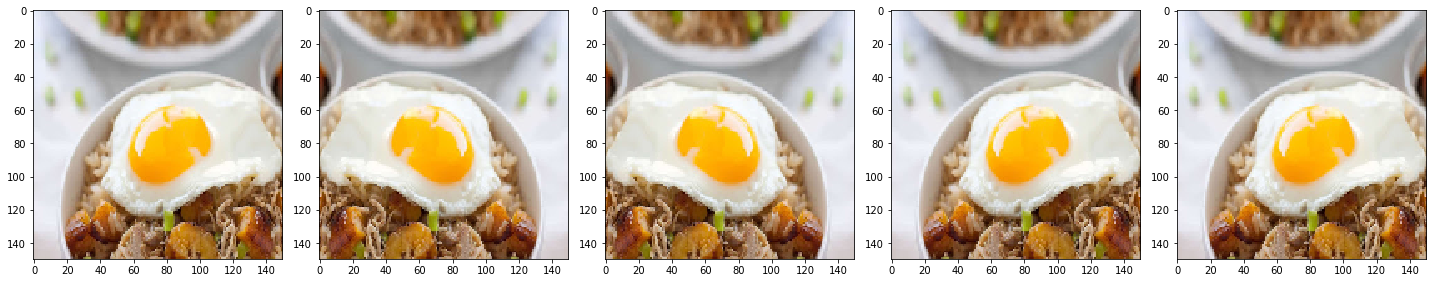

In [6]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[1][0][0] for i in range(5)]
plotImages(augmented_images)

Found 78 images belonging to 2 classes.


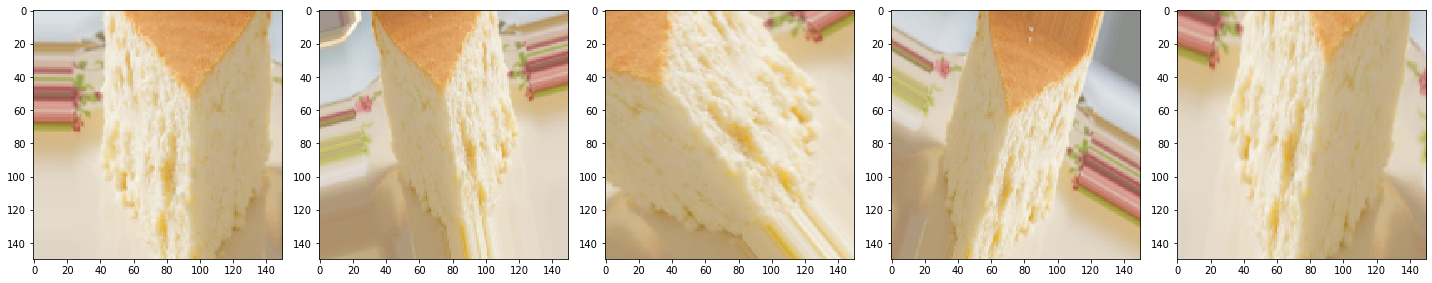

In [7]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [8]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 20 images belonging to 2 classes.


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4320064   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 4,328,513
Trainable params: 4,328,513
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/100
8/8 [==============================] - 1s 175ms/step - loss: 8.3565 - accuracy: 0.5128 - val_loss: 4.8409 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 1s 153ms/step - loss: 2.3196 - accuracy: 0.5385 - val_loss: 2.2358 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 1s 163ms/step - loss: 1.4185 - accuracy: 0.6026 - val_loss: 2.3530 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 1s 167ms/step - loss: 1.5718 - accuracy: 0.6410 - val_loss: 0.9079 - val_accuracy: 0.7000
Epoch 5/100
8/8 [==============================] - 1s 169ms/step - loss: 1.3564 - accuracy: 0.6667 - val_loss: 0.7316 - val_accuracy: 0.7500
Epoch 6/100
8/8 [==============================] - 1s 168ms/step - loss: 1.0843 - accuracy: 0.7051 - val_loss: 1.5205 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 1s 164ms/step - loss: 1.3483 - accuracy: 0.6795 - val_loss: 0.8006 - val_accuracy: 0.7500
Epoch 8/100
8

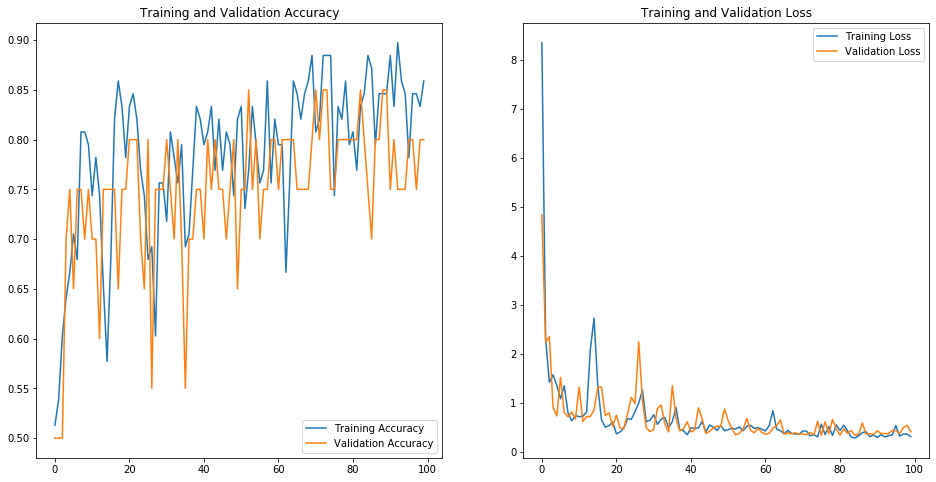

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# read test data
import PIL
import PIL.Image
import pathlib

test_dir = pathlib.Path(test_dir)
image_count = len(list(test_dir.glob('*')))
print('Total test file: ',image_count)

Total test file:  4


In [31]:
test_image = list(test_dir.glob('*'))

test_array = []
y_pred = []

for test_url in test_image:
    test_img = tf.keras.preprocessing.image.load_img(test_url, target_size=(IMG_SHAPE,IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    test_array.append(img_array)
    pred = model.predict(img_array)[0]
    print('Prediction :', pred)
    y_pred.append(int(pred[0]))
    score = tf.nn.softmax(pred)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence score."
        .format(classes[int(pred)], 100 * np.max(score))
    )
#     print('The actual file name is ', os.path.basename(os.path.normpath(test_url)))

Prediction : [1.]
This image most likely belongs to fried_rice with a 100.00 percent confidence score.
Prediction : [0.]
This image most likely belongs to cheesecake with a 100.00 percent confidence score.
Prediction : [0.]
This image most likely belongs to cheesecake with a 100.00 percent confidence score.
Prediction : [1.]
This image most likely belongs to fried_rice with a 100.00 percent confidence score.


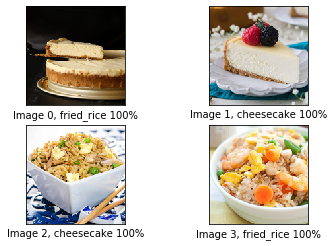

In [34]:
for i in range(len(test_image)):
    predictions_array, img = y_pred[i], test_image[i]

    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = int(predictions_array)


    plt.xlabel("Image {}, {} {:2.0f}%".format(i, classes[predicted_label],100*np.max(score)))

In [35]:
# By default, the 0 is represent cheesecake, while 1 represents fried rice
y_true = [0, 0, 1, 1]

f1_score = f1_score(y_true, y_pred)
print('F1 score is ', f1_score)

F1 score is  0.5
